# 5. Segregation Indexes

Following the Bojanowski & Corten Paper _Measuring Segregation in Social Networks_ 2014, We calculate some segregation indexes for our graphs along the time. First, we import the data and libraries ised for the creation of the functions in the Prerequiste section. Then We calculate The Freeman Segregation Index and the Spectral Segregatoin Index in The next Sections. This Notebook is divided en the following sections.

1. Prerequisites
2. Freeman Segregation

    2.1. Global Freeman Segregation Index

    2.2. Freeman Segregation Index for an specific group

    2.3. Freeman Segregation Index for an specific group (Taking in account Weights)
    
3. Spectral Segregation

4. Results

    4.1. 3 Day Rolling Window
    
4. Conclusion 


## 1. Prerequistes

In [3]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pickle
from glob import glob
from tqdm import tqdm
import random

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: ; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


For the calculation of the segregation Indexes, we define some notation based on (Bojanowski & Corten 2014).

We define a Graph with

$$\mathbb{N}= \{1, \dots, i, \dots, N\}$$

and then, define the set

$$\mathbb{G} = \{G_1, G_2,\dots, G_k\}$$

as the set of $K$ groups in which every $G_g$ is a subset of $\mathbb{N}$ that contains all the nodes that belong to group $g$. 

Now we define the type vector as 

$$\textbf{t} = [t_1,\dots, t_i, \dots, t_N]$$

where $t_i \in \{1,\dots,K\}$. This vector matches every node with its corresponding group. Using this notation. We can define a type indicator vector for each group $k$ as follows:  

$$\textbf{v}_k = [v_1, \dots, v_i, \dots, v_N]$$ 

where $v_i \in \{0,1\}$. This vector has one entry for every node and the node location will have a 1 if that node corresponds to the group $G_k$. Formally:

$$ v_i = \begin{cases} 1 &\text{ if }t_i = k \\ 0 &\text{ if }t_i \neq k \end{cases} $$

Now we define the Types Matrix $T_{N\times K}$ as a matrix that contains the information of each node and wich group it represents. For Every column of the matrix corresponds to a $\textbf{v}_k$ _types indicator vector_.

In the context of this Research, we will use a Directed Weighted Graph. Our nodes are X (formmerly Twitter) in which the user $i$ is related to the user $j$ if $i$ Retweeted a Tweet without comments of $j$. In this sense. Formarly we discribe the relationship $R$ over $\mathbb{N}\times \mathbb{N}$ that implies our square Adjcency Matrix $X = [X_{ij}]_{\mathbb{N}\times \mathbb{N}}$

For the segregation calculations will will consider the graph as weighted or un weight. In case of takin in account the weights of each edge, eh entries of the Adjacency Matrix will be defined as follows:

$$x_{ij} = \dfrac{\text{\# Tweets without comments from }j\text{ that }i\text{ Retweeted}}{\text{\# of Retweets without comments from }i}$$

Taking in account the unweighted graph, we will define our Simple Adjacency Matrix as:

$$ x_{ij} = \begin{cases} 1 & \text{if } iRj \\ 0 & \text{In other case} \end{cases} $$

Finally, we define the _Contact Matrix_ ($M_{gh}$) where $g$ and $h$ are two generic groups. The contact Matrix is defined as follows (Where we use the weighted or un weighted adjcancecy matrix):

$$M_{gh1} = \sum_{i\in G_g}\sum_{j\in G_h} x_{ij}$$

For the **unweighted** case, we can define the _No Contact Matrix_ as follows:

$$M_{gh0} = \sum_{i\in G_g}\sum_{j\in G_h} (1-x_{ij})$$

Finally, in this matrix $M_{gh1}$ shows the amount of attention that group $h$ gets from group $g$

For easyness, we define the follow notation:

- $M_{g+1} = \sum_{g=1}^K M_{gh1}$ Sum across a row
- $M_{+h1} = \sum_{h=1}^K M_{gh1}$ Sum across a column
- $M_{++1} = \sum_{g=1}^K \sum_{h=1}^K M_{gh1}$ Sum of all the Matrix

In [20]:
def get_adjacency(g : gt.Graph, weight = None) -> np.ndarray:
    # Get EdgePropertyMap for Weights in Adjacency
    if weight is not None:
        weights = g.ep[weight]
    else: weights = weight

    adj = gt.adjacency(g, weight = weights).T
    return adj.toarray()

def get_types_array(g: gt.Graph, types = None) -> np.ndarray:
    t = g.vp[types].get_2d_array([0])[0]
    return t

def get_types_dict(g: gt.Graph, types = None) -> dict:
    # Get array of types
    t = get_types_array(g,types)
    T = {}
    for tipo in np.unique(t):
        row=[]
        for i in t:
            if i == tipo:
                row.append(1)
            else:
                row.append(0)        
        T[str(tipo)] = row
    return T

def get_types_index(g: gt.Graph, types = None) -> dict:
    T = get_types_dict(g, types)
    Type_to_row = {k:v for v,k in enumerate(T.keys())}
    return Type_to_row

def get_types_matrix(g: gt.Graph, types = None) -> np.ndarray:
    types_dict = get_types_dict(g,types = types)
    types_vector = types_dict.values()
    return np.array(list(types_vector)).T

def get_contact_matrix(g, types = None, weights = None) -> np.ndarray:
    
    adj = get_adjacency(g, weights)
    
    types_matrix = get_types_matrix(g, types = types)
    
    M = types_matrix.T.dot(adj).dot(types_matrix)

    return M

## 2. Freman Segregation
### 2.1 Global Freeman Segregation Index

For the Freeman Segregation Index, We will use the formula from (Bojanowski & Corten 2014) for the in which the generalize this index for $K$ groups. The index is define as Follows.

Let $p$ be equal to the proportion of _between_ group ties in the graph. This corresponds to the upper triangle of the $M$ Matrix without counting the diagonal (This diagonal contains the information of the _within_ group ties).

$$p = \frac{\sum_{g,h:g\neq h}M_{gh1}}{\sum_{g=1}^K\sum_{h=1}^K M_{gh1}}$$

Now, we define the expected proportion of between-group ties in a random graph. In the generalize case of $K$ groups. this looks like this

$$\pi = \frac{\left( \sum_{k=1}^K \eta_k\right)^2 - \sum_{k=1}^K \eta_k^2}{N(N-1)}$$

Finally, Freeman Segregation Index is defined as:

$$S_{Freeman} = 1 -\frac{p}{\pi} = 1- \frac{pN(N-1)}{\left( \sum_{k=1}^K \eta_k\right)^2 - \sum_{k=1}^K \eta_k^2}$$

This Index takes into account the case **unweighted case**

In [5]:
def Freeman_Global_No_Weight(g: gt.Graph, types = None) -> float:
    """
    Global freeman Segregation Index

    Args:
        g (Graph): The Graph object to analize.
        
        types (String): The name of the PropertyMap where the tipification of the nodes groups resides.

    Returns:
        type: Segregation Index of Freeman

    """
    # Get Relevant Matrices
    types_matrix = get_types_matrix(g, types = types)
    M = get_contact_matrix(g, types=types)
    
    # We get the amount of vertices and groups
    N, K = types_matrix.shape
    # Get the amount of nodes per group
    Eta_k =[]
    for k in range(K):
        Eta = np.sum(types_matrix[:, k])
        Eta_k.append(Eta)
    Eta_k = np.array(Eta_k)
    
    # Calculate In-Between edges
    M_up = np.triu(M,k=1)
    M_low = np.tril(M,k=1)
    between_edges = M_up.sum() + M_low.sum()

    # Calculate P 
    P = between_edges / M.sum()

    # Prepare for calculation
    numerator = P * N * (N - 1)
    denominator = (Eta_k.sum() **2) - (np.sum(Eta_k **2))

    # calculate using the formula
    S = 1 - (numerator / denominator)
    
    return S

### 2.2 Freeman Segregation Index for an specific group

The Freeman Segregation Index is originally computed for the segregation between two groups. This function will compute the index between one group and all the other ones. This will give a measure of how segregated is one group over all the others. For this case, our contact layer will only consider two groups, the group $g$ for which one would calculate the index and the group $-g$ wich are all the other nodes that do not belong to $g$. Recall our _Contact Matrix_ that looks like this:

$$
M_{gh1} = 
\begin{bmatrix}
    M_{1,1,1} & M_{1,2,1} & \dots & M_{1,k,1} \\
    M_{2,1,1} & M_{2,2,1} & \dots & M_{2,k,1} \\
    \vdots & \vdots & \ddots & \vdots \\
    M_{k,1,1} & M_{k,2,1} & \dots & M_{k,k,1} \\
\end{bmatrix}
$$

For our calculation, we will  have another _Contact Catrix_ called, "Me Vs Ohers" and denoted $\hat{M}$. This matrix will be a $2\times 2$. This will be similar as the the original _Contact Matrix_ but with only two groups, $g$ and $-g$. This matrix is defined as follows:

$$
M^* = 
\begin{bmatrix}
    M*_{gg} & M*_{g-g} \\
    M*_{-gg} & M*_{-g-g} \\
\end{bmatrix}
$$

Where:
- $M^*_{g-g} = M_{gg1}$
- $M^*_{g-g} = \sum_{g = 1}^k M_{gh1} - M_{gg1}$
- $M^*_{-gg} = \sum_{h = 1}^k M_{gh1} - M_{gg1}$
- $M^*_{-g-g} = \sum \sum \hat{M}_{gh}$

For the calculation of the $M*_{-g-g1}$ we substract from the original _Contact Matrix_ the index rows and columns for the group $g$ (Will be denoted as $\hat{M}$). This will be the contact matrix if this group hadn't existed. Thanks to this matrix, we can compute all the between ties from all nodes that aren't in $g$. This will be the sum of all the values in the matrix. Formally,
$$
\hat{M} = 
    \begin{bmatrix}
    a_{1,1} & \dots & a_{1,g-1} & a_{1,g+1} & \dots & a_{1,k} \\
    a_{2,1} & \dots & a_{2,g-1} & a_{2,g+1} & \dots & a_{2,k} \\
    \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    a_{g-1,1} & \dots & a_{g-1,g-1} & a_{g-1,g+1} & \dots & a_{g-1,k} \\
    a_{g+1,1} & \dots & a_{g+1,g-1} & a_{g+1,g+1} & \dots & a_{g+1,k} \\
    \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    a_{k,1} & \dots & a_{k,g-1} & a_{k,g+1} & \dots & a_{k,k} \\
\end{bmatrix}
$$

Now, for the Freeman Formula we compute both $P$ and $\pi$ and calculate $1-\frac{P}{\pi}$

$$P = \frac{M^*_{12}}{M^*_{++}}$$

$$\pi = \frac{2|G_g|*|G_{-g}|}{N(N-1)}$$

$$S_{Freeman}^g = 1- \frac{N(N-1)M^*_{12}}{2M^*_{++}|G_g||G_{-g}|}$$

In [12]:
def Freeman_Groups_No_Weight(g: gt.Graph, types:str, group:str) -> float:
    """
    Description of your function.

    Args:
        g (Graph): The Graph object to analize.
        
        types (String): The name of the PropertyMap where the tipification of the nodes groups resides.

        groups (String): The name of the group To calculate the Segregation Index

    Returns:
        type: Segregation Index of Freeman from one group against all the other groups

    """
    # get important stuff
    M = get_contact_matrix(g, types=types)
    groups = get_types_index(g,types)
    groups_list = get_types_dict(g,types=types)[group]
    group_index = groups[group]
    
    # Calculate contact Matrix, One against everyone
    M_11 = M[group_index, group_index]
    M_12 = np.sum(M[group_index,:]) - M_11
    M_21 = np.sum(M[:, group_index]) - M_11
    not_me_contact = np.delete(np.delete(M, group_index, axis=0), group_index, axis=1)
    M_22 = np.sum(not_me_contact)
    
    me_vs_others = np.array([[M_11, M_12],[M_21,M_22]])
    
    # Getting group sizes
    total = g.num_vertices()
    nodes_in_group = sum(groups_list)
    nodes_out_group = g.num_vertices() - nodes_in_group
    
    # Calculating P (Proportion of Between group edges)
    P = me_vs_others[1,2] / np.sum(me_vs_others)
    
    # Calculating Pi (Expected Proportion of Between-group ties in random graph)
    Pi = (2 * nodes_in_group * nodes_out_group) / (total * (total - 1))
    
    return 1 - (P/Pi)

### 2.2 Freeman Segregation Index for an specific group (Taking in account Weights)
The function described below is intended to be use with the weighted graph. We will use precious notation for this formula.

$$P = \frac{M^*_{12}}{M^*_{12} + M^*_{11}}$$

$$\pi = \frac{|G_g|}{N}$$

In this case, the Freeman Segregation Index for a weighted and directed graph is equal to:

$$S_{Freeman}^g = 1-\frac{P}{\pi}$$

In [107]:
def Freeman_Groups_Weight(g: gt.Graph, types:str, group:str, weights:str) -> float:
    """
    Description of your function.

    Args:
        g (Graph): The Graph object to analize.
        
        types (String): The name of the PropertyMap where the tipification of the nodes groups resides.

        weights (String): The name of the EdgePropertyMap where the weights of the edges resides

        groups (String): The name of the group To calculate the Segregation Index

    Returns:
        type: Segregation Index of Freeman from one group against all the other groups using a
            weighted adjacency matrix
    """
    
    # get important stuff
    M = get_contact_matrix(g, types=types, weights=weights)
    groups = get_types_index(g,types)
    groups_list = get_types_dict(g,types=types)[group]
    group_index = groups[group]
    
    # Calculate contact Matrix, Me Vs Others
    M_11 = M[group_index, group_index]
    M_12 = np.sum(M[group_index,:]) - M_11
    M_21 = np.sum(M[:, group_index]) - M_11
    not_me_contact = np.delete(np.delete(M, group_index, axis=0), group_index, axis=1)
    M_22 = np.sum(not_me_contact)
    
    me_vs_others = np.array([[M_11, M_12],[M_21,M_22]])

    # Calculate P
    P = me_vs_others[1,1] / np.sum(me_vs_others[1,:])
            
    # Calculate Pi
    nodes = g.num_vertices()
    nodes_in_group = np.sum(groups_list)
    nodes_out_group = nodes - nodes_in_group

    pi = nodes_out_group / nodes
            
    return 1 - (P / pi)

## 2. 3 Day rolling window Segregation Indexes

### 1. Freeman Segregation Index

In [104]:
# Load graphs
files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')

# Store results
viz_per_group = []
viz_global = []

for file in files:
    g = gt.load_graph(file)
    graph_name = file.split('/')[-1].split('.')[0]
    # Segregation per group
    keys = list(get_types_index(g,types = 'Political Label').keys())
    for key in keys:
        data_per_group = {
            'date': [graph_name],
            'type': [key],
            'Freeman with Weights': [Freeman_Groups_Weight(g, weights='Normal Weights',group = key, types = 'Political Label')],
            'Freeman No Weights': [Freeman_Groups_No_Weight(g, group = key, types = 'Political Label')]
        }
        df = pd.DataFrame(data_per_group, index = None)
        viz_per_group.append(df)
    # Global Measures
    data_global = {
        'Freeman Global': [Freeman_Global_No_Weight(g,types = 'Political Label')],
        'date': [graph_name],
    }
    df = pd.DataFrame(data_global, index = None)
    viz_global.append(df)
# We create a Dataframe for Visualization
viz_per_group = pd.concat(viz_per_group)
viz_global = pd.concat(viz_global)

# Transform the list to a big dataframe
viz_per_group['date'] = pd.to_datetime(viz_per_group['date'], format='%Y-%m-%d')
viz_per_group = viz_per_group.set_index('date')
viz_per_group = viz_per_group.sort_index()

# Transform the list to a big dataframe
viz_global['date'] = pd.to_datetime(viz_global['date'], format='%Y-%m-%d')
viz_global = viz_global.set_index('date')
viz_global = viz_global.sort_index()

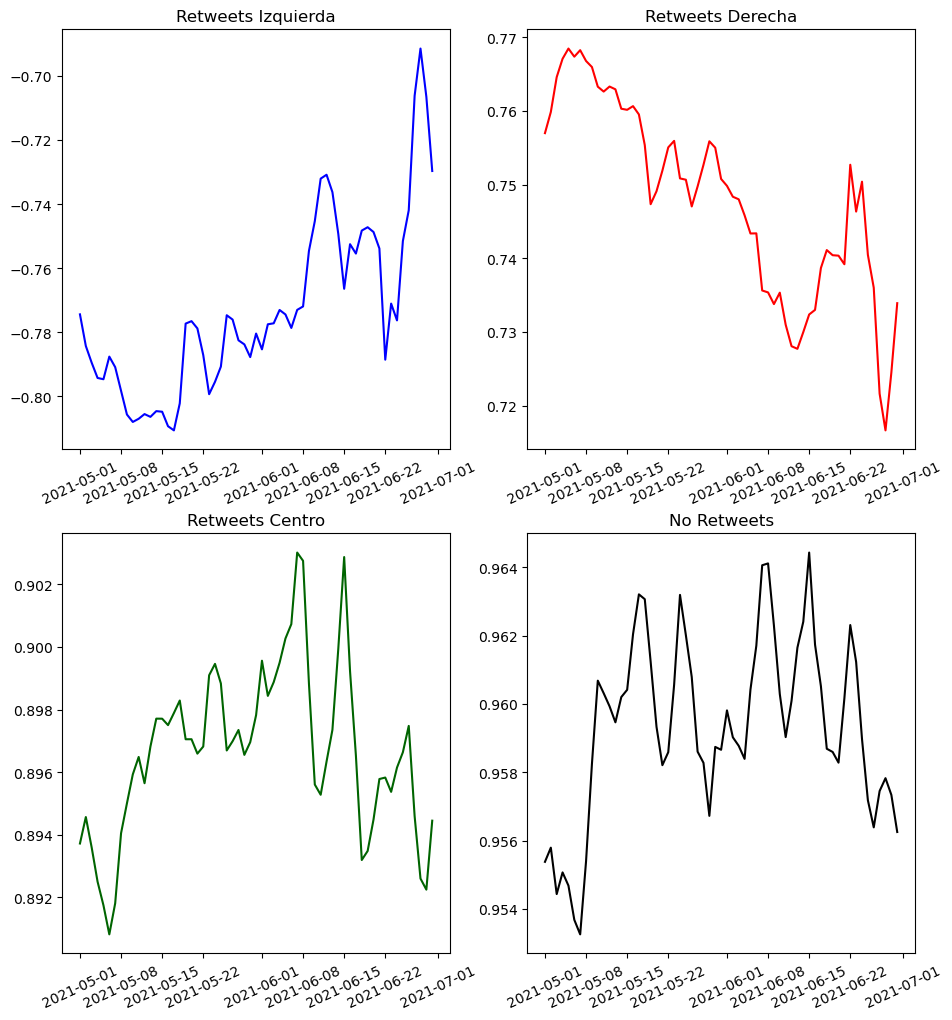

In [109]:
# Calculating number of axes
sq = int(np.ceil((np.sqrt(len(viz_per_group['type'].unique())))))
fig, axes = plt.subplots(nrows=sq, ncols=sq, figsize=(11,12))

# ColorMap
color = {
    'Retweets Izquierda': 'blue',
    'Retweets Derecha': 'red',
    'Retweets Centro': 'darkgreen',
    'No Retweets': 'black'
}

for i, type in enumerate(viz_per_group['type'].unique()):
    seg = viz_per_group[viz_per_group['type'] == type]
    ax = axes[i // sq, i % sq]
    sns.lineplot(data=seg, x=seg.index, y='Freeman with Weights', color=color[type], ax=ax)
    
    ax.set_title(type)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=25)
    ax.set_title(type)
    ax.set_ylabel('')
        

#plt.suptitle('Line Plots by Type')
plt.show()

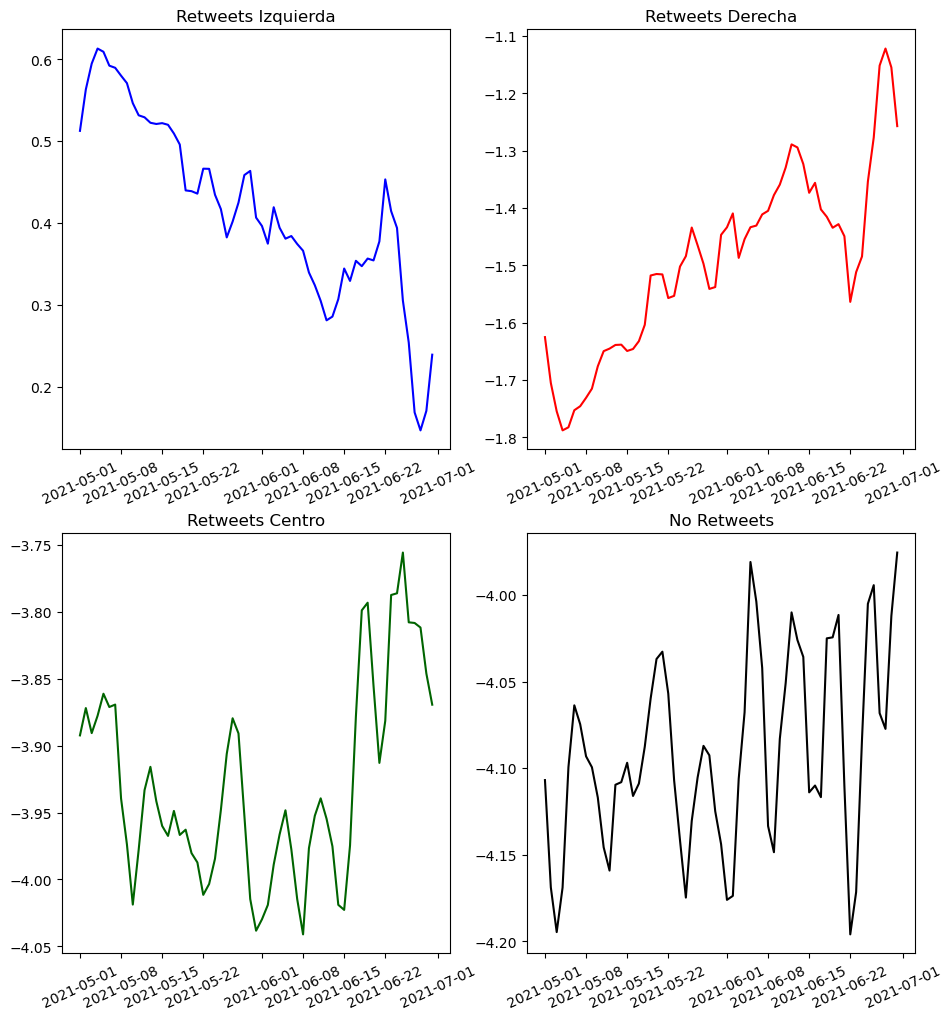

In [110]:
fig, axes = plt.subplots(nrows=sq, ncols=sq, figsize=(11,12))

for i, type in enumerate(viz_per_group['type'].unique()):
    seg = viz_per_group[viz_per_group['type'] == type]
    ax = axes[i // sq, i % sq]
    sns.lineplot(data=seg, x=seg.index, y='Freeman No Weights', color=color[type], ax=ax)
    
    ax.set_title(type)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=25)
    ax.set_title(type)
    ax.set_ylabel('')
        
plt.show()

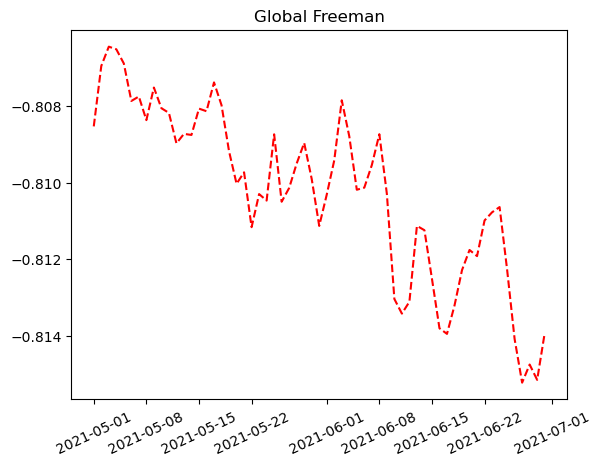

In [113]:
fig, ax = plt.subplots()
sns.lineplot(data=viz_global, x=viz_global.index, y='Freeman Global', color='red', ax=ax, linestyle='--')
    
ax.set_title('Freeman Global')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=25)
ax.set_title('Global Freeman')
ax.set_ylabel('')

plt.show()

### 2. Spectral Segregation Index

In [ ]:
# Load Adjacency matrices
files = glob('/mnt/disk2/Data/Matrices/3_Day_Window/*csr.npz')
viz_per_group = []

# This takes a While XD (runtime: 1 Hour aprox)
for file in files:
    #Loading the Adjacency Matrix as CRS
    data = np.load(file)
    indices = data['indices']
    indptr = data['indptr']
    shape = data['shape']
    data = data['data']
    adj = sp.csr_matrix((data, indices, indptr), shape = shape)

    #Getting the name of the Matrix
    adjacency_name = file.split('/')[-1].split('.')[0].split('_')[-1]

    data = Spectral_Segregation_Index(adj,types,user_indices)
    data['date'] = adjacency_name

    #Appending it to the data Visualization list
    viz_per_group.append(data)

# We create a Dataframe for Visualization
viz_per_group = pd.concat(viz_per_group)

# Transform the list to a big dataframe
viz_per_group['date'] = pd.to_datetime(viz_per_group['date'], format='%d-%m-%Y')

# Pivot to long format
viz_per_group = pd.melt(viz_per_group,
                    id_vars=['date'],
                    value_vars=['Dummy Derecha', 'Dummy Centro', 'No Retweets'], var_name='Group', value_name='segregation')

print("DataFrame in long format:")
viz_per_group.head()

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


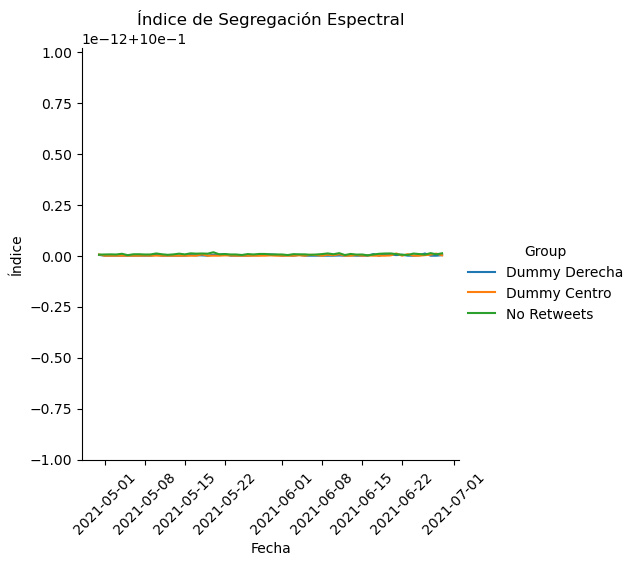

In [10]:
# Figure Mapping
sns.relplot(data = viz_per_group,
            x ='date',
            y = 'segregation',
            kind = 'line',
            hue = 'Group')

# Labels
plt.title('Índice de Segregación Espectral')
plt.ylabel('Índice')
plt.xlabel('Fecha')

# Others
plt.xticks(rotation=45)
plt.show()